In [1]:
! rm *.csv
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/global_power_plant_database_last.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-elec-produc-by-source.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/share-energy-consum-by-source.csv /content/
! wget https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/population_by_country_2020.csv /content/

rm: cannot remove '*.csv': No such file or directory
--2022-05-26 09:37:29--  https://raw.githubusercontent.com/s1102498/Global_Energy_Analysis/main/Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145200 (142K) [text/plain]
Saving to: ‘Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv’

Primary-energy-cons 100%[===================>] 141.80K  --.-KB/s    in 0.02s   

2022-05-26 09:37:29 (8.16 MB/s) - ‘Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv’ saved [145200/145200]

/content/: Scheme missing.
FINISHED --2022-05-26 09:37:29--
Total wall clock time: 0.2s
Downloaded: 1 files, 142K in 0.02s (8.16 MB/s)
--2022-05-26 09:37:29--  https://raw.githubusercontent

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # To transform the dataset
from sklearn import metrics
import seaborn as sns

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.datasets import load_nfl

In [3]:
energy_cons        = pd.read_csv("Primary-energy-consumption-from-fossilfuels-nuclear-renewables.csv", low_memory=False)
power_plant        = pd.read_csv("global_power_plant_database_last.csv", low_memory=False)
elec_prod_source   = pd.read_csv("share-elec-produc-by-source.csv", low_memory=False)
energy_cons_source = pd.read_csv("share-energy-consum-by-source.csv", low_memory=False)
popolation = pd.read_csv("population_by_country_2020.csv", low_memory=False)

power_plant dataset contains informations about gwh of energy estimated and generated for each country and the type of energy from 2013 to 2017

In [4]:
power_plant.head()

,country,country_long,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,...,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017,estimated_generation_note_2013,estimated_generation_note_2014,estimated_generation_note_2015,estimated_generation_note_2016,estimated_generation_note_2017
0,AFG,Afghanistan,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.0,32.322,65.1190,Hydro,NaN,NaN,...,123.77,162.90,97.39,137.76,119.50,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
1,AFG,Afghanistan,Kandahar DOG,WKS0070144,10.0,31.670,65.7950,Solar,NaN,NaN,...,18.43,17.48,18.25,17.70,18.29,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
2,AFG,Afghanistan,Kandahar JOL,WKS0071196,10.0,31.623,65.7920,Solar,NaN,NaN,...,18.64,17.58,19.10,17.62,18.72,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE,SOLAR-V1-NO-AGE
3,AFG,Afghanistan,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.0,34.556,69.4787,Hydro,NaN,NaN,...,225.06,203.55,146.90,230.18,174.91,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1
4,AFG,Afghanistan,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.0,34.641,69.7170,Hydro,NaN,NaN,...,406.16,357.22,270.99,395.38,350.80,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1,HYDRO-V1


## Preprocessing power plant
Questo dataset contiene informazioni circa la produzione annua di energia (dal 2013 al 2019) dei paesi. Ogni riga mostra i megawhat ora prodotta in ogni anno per ogni tipo di energia e per ogni centrale.

Bisogna, per ogni paese, creare n righe (1 per ogni anno) dove mettiamo per ogni primary fuel la produzione di energia.

In [5]:
years = list(set(map(lambda column: f"y20{column.split('20')[1]}",
            filter(lambda column: str.startswith(column, "generation_gwh"), power_plant.columns))))
years.sort()
codes       = set(power_plant.country)

energy_type = set(power_plant.primary_fuel) #type of energy 

In [6]:
# i valori mancati dell'energia generata sono stati fillati con quelli stimati
for i in years:
  if(i == "y2018" or i == "y2019"):
    power_plant[i] = power_plant[f"generation_gwh_{i[1:]}"]
  else:
    power_plant[i] = power_plant[f"generation_gwh_{i[1:]}"].fillna(power_plant[f"estimated_generation_gwh_{i[1:]}"])

Prepocessing della tabella, mantendendo solo contry, tipologia di fuel, capacity mw e gli anni dal 2013 al 2019 di gwh prodotti

In [7]:
pp = power_plant[["country","country_long", "capacity_mw", "primary_fuel", "commissioning_year"] + list(years)]

In [8]:
#.dropna(subset = list(years), axis = 0, how = "all").interpolate(method = 'barycentric',limit_direction = "both", axis = 1)
pp_d = pp.dropna(subset = list(years), axis = 0, how = "all")
pp_d["mean"] = pp_d[years].mean(axis = 1)
pp_d.loc[:, years+["mean"]] = pp_d.loc[:, years+["mean"]].fillna(method = "backfill", axis = 1)
years_int = np.array(list(map(lambda x: int(x[1:]), years)))
years_str = np.array(years)
for index, row in  pp_d.loc[pp_d.commissioning_year >= 2013,years + ["commissioning_year"]].iterrows():
  val = row.commissioning_year
  year = years_str[years_int < val]
  pp_d.loc[index,year] = 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

abbiamo trasformato le righe del primary fuel in colonne, e le colonne dei ralativi anni in un'unica colonna "year", in modo da avere per ogni riga il totale di gwh prodotti da ogni nazione in un anno specifico (dal 2013 al 2019) con il relativo valore di gwh prodotti per tipologia di fuel.
I valori mancanti nei dati 2018 e 2019 sono stati fillati utilizzando la media degli anni precedenti.

In [9]:
df = pp_d.groupby(["country_long", "primary_fuel"]).sum().drop(["mean", "commissioning_year"], axis = 1).reset_index()
df = df.melt(id_vars = ["country_long","primary_fuel", "capacity_mw"], var_name="year", value_vars=years)
df = df.pivot_table("value", ["country_long","year","capacity_mw"], "primary_fuel").reset_index().groupby(["year","country_long"]).sum().reset_index()
df.year = df.year.apply(lambda x: int(x[1:]))
df["total_gwh"] = df[df.columns[4:]].sum(axis = 1)

E' stato joinato il dataset della popolazione per ogni nazione in maniera da avere i gwh prodotti procapite

In [10]:
popolation = pd.read_csv("population_by_country_2020.csv", low_memory=False)
popolations = popolation[['Country (or dependency)', 'Population (2020)']]
popolations.rename(columns = {'Country (or dependency)' : 'country_long', 'Population (2020)':'population'}, inplace = True)
popolations.loc[popolations["country_long"] == "United States", "country_long"] = "United States of America"
popolations.loc[popolations["country_long"] == "Czech Republic (Czechia)", "country_long"] = "Czech Republic"
popolations.loc[popolations["country_long"] == "State of Palestine", "country_long"] = "Palestine"
popolations.loc[popolations["country_long"] == "Côte d'Ivoire", "country_long"] = "Cote DIvoire"
popolations.loc[popolations["country_long"] == "Congo", "country_long"] = "Democratic Republic of the Congo"
popolations.loc[popolations["country_long"] == "DR Congo", "country_long"] = "Congo"
popolations.loc[popolations["country_long"] == "Cabo Verde", "country_long"] = "Cape Verde"
popolations.loc[popolations["country_long"] == "North Macedonia", "country_long"] = "Macedonia"
popolations.loc[popolations["country_long"] == "Eswatini", "country_long"] = "Swaziland"
popolations.loc[popolations["country_long"] == "Brunei", "country_long"] = "Brunei Darussalam"
popolations.loc[popolations["country_long"] == "Syria", "country_long"] = "Syrian Arab Republic"


df_copy = df.merge(popolations, on='country_long', how='left')

df_copy["gwh/population"] = df_copy["total_gwh"] / df_copy["population"]
len(df_copy["country_long"].unique())



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


160

In [11]:
scaled_df = df_copy.copy()
for en in scaled_df.columns[2:]:
  #scaled_df[en]=(scaled_df[en]-scaled_df[en].min())/(scaled_df[en].max()-scaled_df[en].min())
  scaled_df[en] = scaled_df[en] / 1#scaled_df[en].max()
scaled_df

,year,country_long,capacity_mw,Biomass,Coal,Cogeneration,Gas,Geothermal,Hydro,Nuclear,Oil,Other,Petcoke,Solar,Storage,Waste,Wind,total_gwh,population,gwh/population
0,2013,Afghanistan,258.550,0.0,0.00,0.0,0.000,0.0,958.980,0.00,0.00,0.0,0.0,37.070,0.0,0.0,0.00,996.050,39074280.0,0.000025
1,2013,Albania,1431.000,0.0,0.00,0.0,0.000,0.0,5259.640,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.00,5259.640,2877239.0,0.001828
2,2013,Algeria,15873.800,0.0,0.00,0.0,52958.240,0.0,30.810,0.00,0.00,0.0,0.0,1145.470,0.0,0.0,0.00,54134.520,43984569.0,0.001231
3,2013,Angola,1071.180,0.0,0.00,0.0,0.000,0.0,2330.550,0.00,389.82,0.0,0.0,0.000,0.0,0.0,0.00,2720.370,33032075.0,0.000082
4,2013,Argentina,32913.079,0.0,25175.76,0.0,72711.230,0.0,24035.380,3587.53,5433.02,0.0,0.0,1173.120,0.0,0.0,1330.13,133446.170,45267449.0,0.002948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,2019,Venezuela,31096.000,0.0,0.00,0.0,39062.665,0.0,79653.804,0.00,0.00,0.0,0.0,0.000,0.0,0.0,0.00,118716.469,28421581.0,0.004177
1116,2019,Vietnam,41328.490,0.0,70339.02,0.0,60848.990,0.0,58105.342,0.00,395.05,0.0,0.0,3091.208,0.0,0.0,376.08,193155.690,97490013.0,0.001981
1117,2019,Yemen,1045.000,0.0,0.00,0.0,1422.820,0.0,0.000,0.00,1384.51,0.0,0.0,0.000,0.0,0.0,0.00,2807.330,29935468.0,0.000094
1118,2019,Zambia,2677.100,0.0,2131.66,0.0,0.000,0.0,10044.404,0.00,623.38,0.0,0.0,129.788,0.0,0.0,0.00,12929.232,18468257.0,0.000700


## Condensazione dati in Rinnovabile, Nucleare e Fossile
Preparazione di un dataset ristretto per il clustering, creando nuove colonne

In [12]:
renewables = ["Biomass", "Hydro", "Solar", "Waste", "Wind"]
nuclear = ["Nuclear"]
fossil = ["Coal", "Cogeneration", "Gas", "Geothermal", "Oil", "Petcoke"]
scaled_df["renewables"] = scaled_df[renewables].sum(axis=1)
scaled_df["fossil"] = scaled_df[fossil].sum(axis=1)

scaled_df["not_fossil"] = scaled_df["renewables"] + scaled_df["Nuclear"]
scaled_df["not_fossil/pop"] = scaled_df["not_fossil"] / scaled_df["population"]
scaled_df["fossil/pop"] = scaled_df["fossil"] / scaled_df["population"]
scaled_df["renewables/pop"] = scaled_df["renewables"] / scaled_df["population"]



In [13]:
scaled_df.drop(columns=["capacity_mw","Biomass","Coal", "Cogeneration","Gas","Geothermal","Hydro",'Oil', 'Other',
       'Petcoke', 'Solar', 'Storage', 'Waste', 'Wind', 'total_gwh'], inplace=True)

## Correlazioni

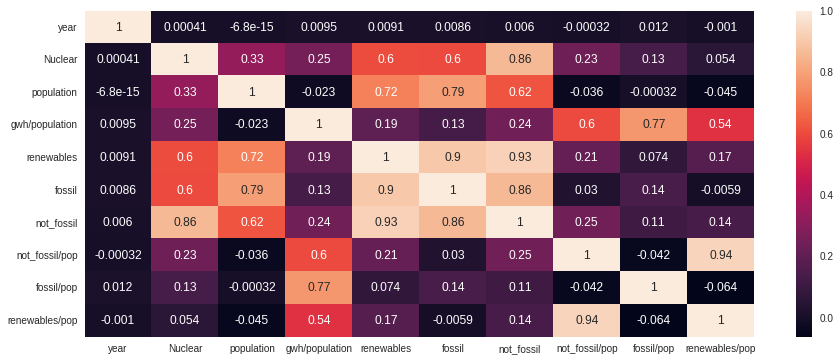

In [14]:
#matrice di correlazione tra le variabili
correlation = scaled_df.corr()
plt.figure(figsize = (15,6))
sns.heatmap(correlation, annot = True)

## Clusterizziamo le nazioni che abbandonano il fossile

1) Analizziamo i GWh procapite prodotti da fonti rinnovabili rispetto i GWh procapite totali

In [15]:
def plot_silhouette(df, cols, n_cl):

  # Specify the features to use for clustering
  features = cols
  X = df[features]

  # Instantiate the clustering model and visualizer
  model = KMeans(n_cl, random_state=42)
  visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

  visualizer.fit(X)        # Fit the data to the visualizer
  visualizer.show()        # Finalize and render the figure

Tested kMeans with k = 2	SS: 0.7614
Tested kMeans with k = 3	SS: 0.6213
Tested kMeans with k = 4	SS: 0.6251
Tested kMeans with k = 5	SS: 0.6079
Tested kMeans with k = 6	SS: 0.5641
Tested kMeans with k = 7	SS: 0.5682
Tested kMeans with k = 8	SS: 0.5704
Tested kMeans with k = 9	SS: 0.5892


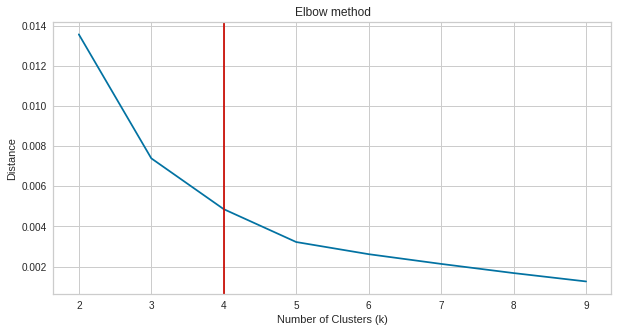

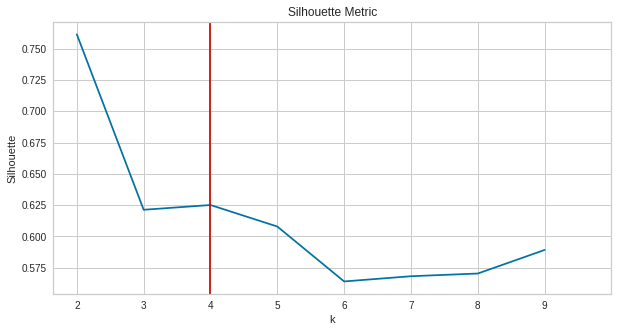

label: 0 = 758
label: 1 = 28
label: 2 = 21
label: 3 = 313


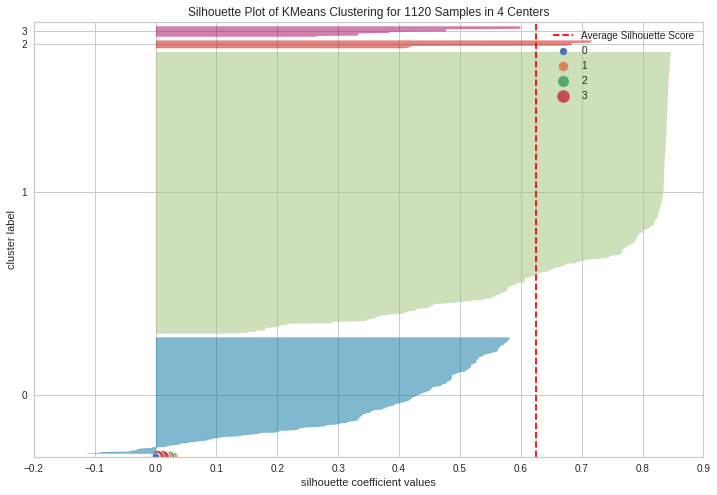

In [16]:

k_to_test = range(2,10,1) 
silhouette_scores = {}
considered_columns = ["gwh/population", "renewables/pop"]
clustering_dataframe = scaled_df[considered_columns]

avg_distance=[]

for k in k_to_test:
    model_kmeans_k = KMeans( n_clusters = k, random_state=42 )
    model_kmeans_k.fit(clustering_dataframe)
    labels_k = model_kmeans_k.labels_
    score_k = metrics.silhouette_score(clustering_dataframe, labels_k)
    silhouette_scores[k] = score_k
    print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))

    clusterer = KMeans(n_clusters=k, random_state=42).fit(clustering_dataframe)
    avg_distance.append(clusterer.inertia_)

plt.figure(figsize = (10,5))
plt.title("Elbow method")
plt.plot(k_to_test, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.axvline(4, color = "r")
plt.show()

plt.figure(figsize = (10,5))
plt.plot(list(silhouette_scores.values()))
plt.xticks(range(0,9), silhouette_scores.keys())
plt.title("Silhouette Metric")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.axvline(2, color = "r")
plt.show()

cols = ["renewables/pop","gwh/population"]
clustering_dataframe = clustering_dataframe[cols]
best_n_clusters = 4
Kmeans = KMeans(n_clusters = best_n_clusters)
Kmeans.fit(clustering_dataframe)
label = Kmeans.labels_
df["kmeans"] = label

X = clustering_dataframe.copy()
X["label"] = label
plt.figure(figsize=(12,8))
sns.scatterplot(x = "gwh/population", y = "renewables/pop", data = X, hue=X["label"], palette = "deep", size=X["label"], sizes=(50, 150),legend=True)
scaled_df["label"] = df["kmeans"]
for i in range(len(scaled_df["label"].unique())):
  temp = scaled_df["label"].loc[scaled_df["label"] == i].count()
  print(f"label: {i} = {temp}")

plot_silhouette(scaled_df, ["gwh/population", "renewables/pop"], 4)

In [17]:
df.loc[df.kmeans == 3]

primary_fuel,year,country_long,capacity_mw,Biomass,Coal,Cogeneration,Gas,Geothermal,Hydro,Nuclear,Oil,Other,Petcoke,Solar,Storage,Waste,Wind,total_gwh,kmeans
5,2013,Armenia,3.271000e+03,0.000000,0.000000,0.000,1.167788e+04,0.000,1412.420000,2411.040000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,1.550134e+04,3
6,2013,Australia,6.534032e+04,75.441389,152893.329167,0.000,5.277399e+04,0.000,24452.606111,0.000000,12374.504444,0.000000,0.000000,8869.157778,0.000,731.760278,14753.897222,2.668492e+05,3
7,2013,Austria,1.122710e+04,0.000000,0.000000,0.000,3.957943e+03,0.000,31427.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,65.230000,3.545102e+04,3
12,2013,Belgium,1.330980e+04,1564.476000,2074.791000,0.000,1.580987e+04,0.000,3560.660000,32162.300000,41.880000,0.000000,0.000000,170.070000,0.000,374.800000,3141.781000,5.733615e+04,3
14,2013,Bhutan,1.482200e+03,0.000000,0.000000,0.000,0.000000e+00,0.000,5009.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,5.009120e+03,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,2019,Ukraine,4.856980e+04,0.000000,52739.150000,0.000,4.217900e+03,0.000,18000.336000,85298.530000,0.000000,0.000000,0.000000,1117.836000,0.000,0.000000,0.000000,1.613738e+05,3
1111,2019,United Kingdom,9.163068e+04,0.000000,18782.826500,0.000,1.371199e+05,0.000,17979.430000,61051.600000,202.080000,0.000000,0.000000,12984.734000,0.000,7577.526500,58488.680000,3.141868e+05,3
1112,2019,United States of America,1.204616e+06,25714.175348,942425.526596,3888.141,1.588207e+06,15545.705,283074.899348,807145.551995,25419.389978,1624.722993,6967.578932,72070.572330,-33.934,44376.903096,293919.605650,4.084631e+06,3
1113,2019,Uruguay,3.530700e+03,0.000000,0.000000,0.000,0.000000e+00,0.000,7434.526000,0.000000,57.580000,0.000000,0.000000,442.466000,0.000,0.000000,3441.290000,1.137586e+04,3


2) Analizziamo la produzione di energia rinnovabile rispetto la popolazione

Tested kMeans with k = 2	SS: 0.9693
Tested kMeans with k = 3	SS: 0.8208
Tested kMeans with k = 4	SS: 0.7414
Tested kMeans with k = 5	SS: 0.7017
Tested kMeans with k = 6	SS: 0.7048
Tested kMeans with k = 7	SS: 0.6752
Tested kMeans with k = 8	SS: 0.6731
Tested kMeans with k = 9	SS: 0.6055


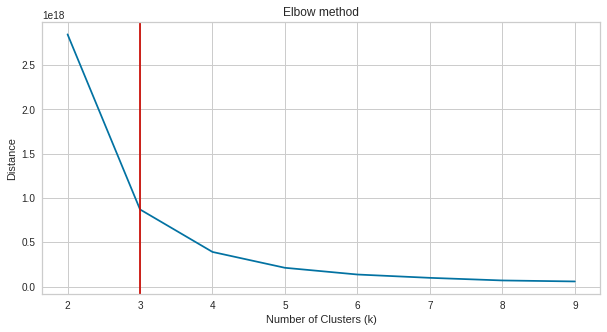

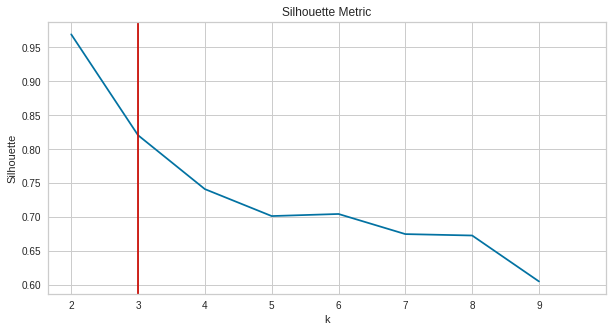

(3, 2)
label: 0 = 1015
label: 1 = 14
label: 2 = 91


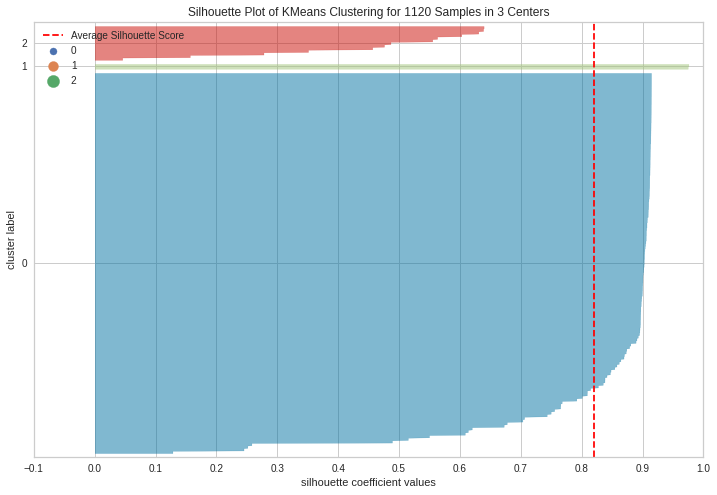

In [18]:
k_to_test = range(2,10,1) # [2,3,4, ..., 24]
silhouette_scores = {}
considered_columns = ["population", "renewables"]
clustering_dataframe = scaled_df[considered_columns]

avg_distance = []

for k in k_to_test:
    model_kmeans_k = KMeans( n_clusters = k )
    model_kmeans_k.fit(clustering_dataframe)
    labels_k = model_kmeans_k.labels_
    score_k = metrics.silhouette_score(clustering_dataframe, labels_k)
    silhouette_scores[k] = score_k
    print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))

    clusterer = KMeans(n_clusters=k, random_state=42).fit(clustering_dataframe)
    avg_distance.append(clusterer.inertia_)


plt.figure(figsize = (10,5))
plt.title("Elbow method")
plt.plot(k_to_test, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.axvline(3, color = "r")
plt.show()

plt.figure(figsize = (10,5))
plt.plot(list(silhouette_scores.values()))
plt.xticks(range(0,9), silhouette_scores.keys())
plt.title("Silhouette Metric")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.axvline(1, color = "r")
plt.show()

cols = ["renewables","population"]
clustering_dataframe = clustering_dataframe[cols]
best_n_clusters = 3
Kmeans = KMeans(n_clusters = best_n_clusters)
Kmeans.fit(clustering_dataframe)
print(Kmeans.cluster_centers_.shape) #3 centroidi per 6 coordinate
label = Kmeans.labels_
df["kmeans"] = label
X = clustering_dataframe.copy()

X["label"] = label
plt.figure(figsize=(12,8))
sns.scatterplot(x = "population", y = "renewables", data = X, hue=X["label"], palette = "deep", size=X["label"], sizes=(50, 150),legend=True)
scaled_df["label"] = df["kmeans"]
for i in range(len(scaled_df["label"].unique())):
  temp = scaled_df["label"].loc[scaled_df["label"] == i].count()
  print(f"label: {i} = {temp}")

plot_silhouette(scaled_df, ["population", "renewables"], 3)

In [19]:
scaled_df.loc[scaled_df["label"] == 1,"country_long"].unique()

array(['China', 'India'], dtype=object)

In [20]:
scaled_df.loc[scaled_df["label"] == 1, "country_long"].unique()

array(['China', 'India'], dtype=object)

Tested kMeans with k = 2	SS: 0.7553
Tested kMeans with k = 3	SS: 0.7800
Tested kMeans with k = 4	SS: 0.6219
Tested kMeans with k = 5	SS: 0.5407
Tested kMeans with k = 6	SS: 0.5930
Tested kMeans with k = 7	SS: 0.6008
Tested kMeans with k = 8	SS: 0.5906
Tested kMeans with k = 9	SS: 0.5654


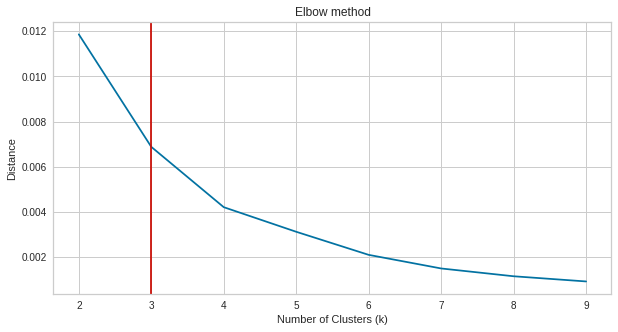

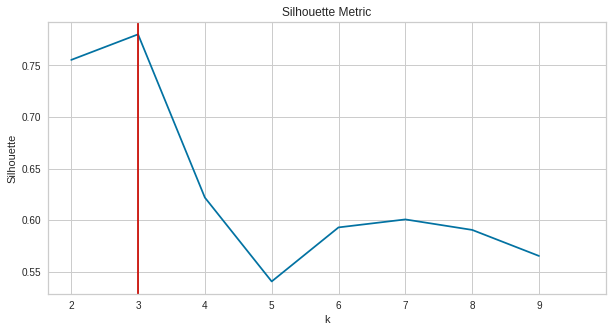

label: 0 = 1032
label: 1 = 67
label: 2 = 21


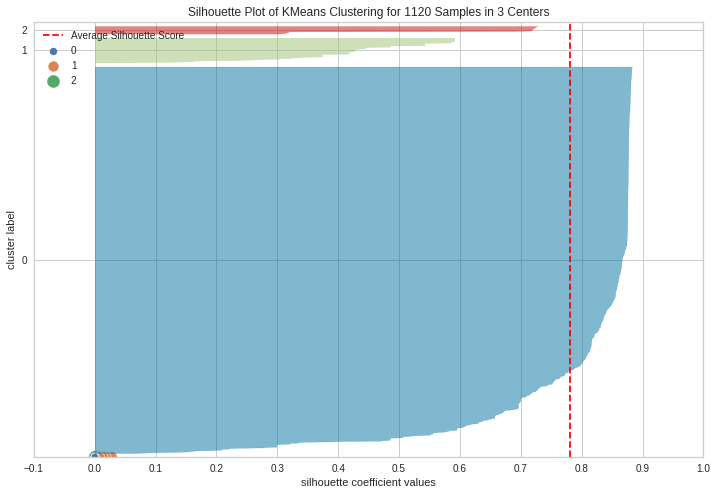

In [21]:
k_to_test = range(2,10,1) 
silhouette_scores = {}
considered_columns = ["fossil/pop", "renewables/pop"]
clustering_dataframe = scaled_df[considered_columns]
avg_distance = []

for k in k_to_test:
    model_kmeans_k = KMeans( n_clusters = k )
    model_kmeans_k.fit(clustering_dataframe)
    labels_k = model_kmeans_k.labels_
    score_k = metrics.silhouette_score(clustering_dataframe, labels_k)
    silhouette_scores[k] = score_k
    print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))

    clusterer = KMeans(n_clusters=k, random_state=42).fit(clustering_dataframe)
    avg_distance.append(clusterer.inertia_)

plt.figure(figsize = (10,5))
plt.title("Elbow method")
plt.plot(k_to_test, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.axvline(3, color = "r")
plt.show()

plt.figure(figsize = (10,5))
plt.plot(list(silhouette_scores.values()))
plt.xticks(range(0,9), silhouette_scores.keys())
plt.title("Silhouette Metric")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.axvline(1, color = "r")
plt.show()

cols = ["renewables/pop","fossil/pop"]
clustering_dataframe = clustering_dataframe[cols]
best_n_clusters = 3 #4
Kmeans = KMeans(n_clusters = best_n_clusters)
Kmeans.fit(clustering_dataframe)
label = Kmeans.labels_
df["kmeans"] = label

X = clustering_dataframe.copy()
X["label"] = label
plt.figure(figsize=(12,8))
sns.scatterplot(x = "fossil/pop", y = "renewables/pop", data = X, hue=X["label"], palette = "deep", size=X["label"], sizes=(50, 150),legend=True)
scaled_df["label"] = df["kmeans"]
for i in range(len(scaled_df["label"].unique())):
  temp = scaled_df["label"].loc[scaled_df["label"] == i].count()
  print(f"label: {i} = {temp}")

plot_silhouette(scaled_df, ["fossil/pop", "renewables/pop"], 3)


## Classificazione
Nazioni "green", "not_green", "verso il green", "ancora legate al fossile"


In [22]:
min_num_el = 1e6
lens_vec = []

for i in range(len(scaled_df["label"].unique())):
  temp = scaled_df["label"].loc[scaled_df["label"] == i].count()
  print(f"label: {i} = {temp}")
  lens_vec.append(temp)
  if temp < min_num_el:
    min_num_el = temp

print("min:", min_num_el)

label: 0 = 1032
label: 1 = 67
label: 2 = 21
min: 21


#### Oversampling

In [23]:
considered_columns = ["label","renewables/pop","fossil/pop"]
classification_df = scaled_df[considered_columns]
label = scaled_df["label"]

In [24]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


X = classification_df
y = label
print(Counter(label))
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))


Counter({0: 1032, 1: 67, 2: 21})
Class=0, n=1032 (33.333%)
Class=1, n=1032 (33.333%)
Class=2, n=1032 (33.333%)


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0, stratify=y)

In [26]:
X_train = X_train.drop(columns=["label"])
X_test = X_test.drop(columns=["label"])

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2167, 2)
(929, 2)
(2167,)
(929,)


Accuracy: 0.9924650161463939
Precision Score :  0.9924650161463939
Recall Score :  0.9924650161463939


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


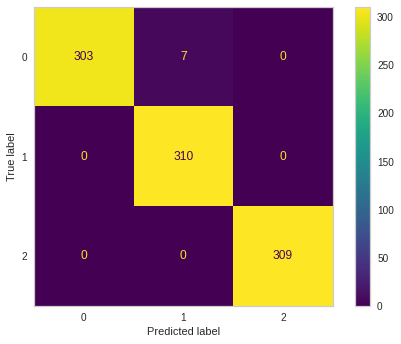

In [63]:
from pandas.core.common import random_state
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


clf = svm.SVC()
knn = KNeighborsClassifier(n_neighbors=800)

knn.fit(X_train, y_train)
clf.fit(X_train, y_train)

#y_pred = knn.predict(X_test)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_pred, y_test))
print("Precision Score : ",metrics.precision_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",metrics.recall_score(y_test, y_pred, 
                                           pos_label='positive',
                                           average='micro'))


plot_confusion_matrix(clf, X_test, y_test)
# Configurazione Senza griglia e con colore diverso
#plot_confusion_matrix(knn, X_test, y_test, cmap='YlGnBu')
plt.grid(False)   
plt.show()

Accuracy: 0.9472551130247578
Precision Score :  0.9472551130247578
Recall Score :  0.9472551130247578


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


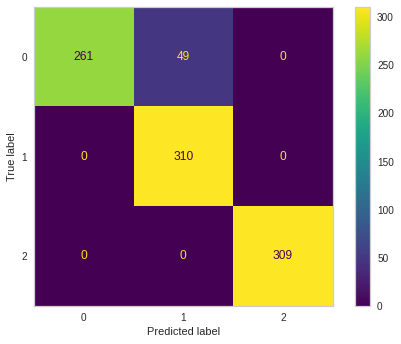

In [110]:
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

RF = RandomForestClassifier(n_estimators=1, max_depth=3)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision Score : ",metrics.precision_score(y_test, y_pred, pos_label='positive',average='micro'))
print("Recall Score : ",metrics.recall_score(y_test, y_pred, pos_label='positive',average='micro'))

plot_confusion_matrix(RF, X_test, y_test)
# Configurazione Senza griglia e con colore diverso
#plot_confusion_matrix(knn, X_test, y_test, cmap='YlGnBu')
plt.grid(False)   
plt.show()

Accuracy: 0.333692142088267
Precision Score :  0.333692142088267
Recall Score :  0.333692142088267
Accuracy: 0.33317951084448544


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


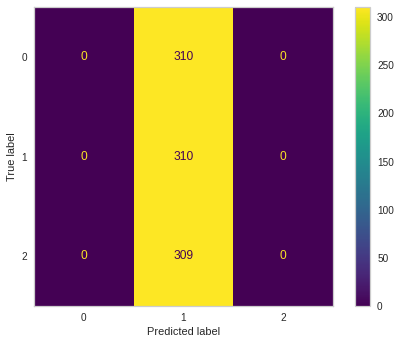

In [41]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='sgd')
NN.fit(X_train, y_train)

y_pred = NN.predict(X_test)
y_pred_train = NN.predict(X_train)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision Score : ",metrics.precision_score(y_test, y_pred, pos_label='positive',average='micro'))
print("Recall Score : ",metrics.recall_score(y_test, y_pred, pos_label='positive',average='micro'))

print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))


plot_confusion_matrix(NN, X_test, y_test)
# Configurazione Senza griglia e con colore diverso
#plot_confusion_matrix(knn, X_test, y_test, cmap='YlGnBu')
plt.grid(False)   
plt.show()